# Neural dimensionality reduction

# Introduction

📊 In this notebook, we will analyze how dimensionality reduction can be performed using a neural network. Dimensionality reduction is a crucial aspect of data analysis as it simplifies complex datasets, reduces noise, improves data visualization, and decreases computation times for machine learning models.

In particular, we will explore different types of neural networks, highlighting the main differences compared to traditional methods such as t-SNE and PCA. PCA, or Principal Component Analysis, is based on a linear decomposition of variances, which transforms the original data into a new coordinate system where the maximum variance of the data is captured along the first axes, thus allowing for effective dimensionality reduction. In contrast, t-SNE is a non-linear visualization technique that preserves local distances between data points, making it useful for visualizing complex structures in high-dimensional data.

Additionally, we will explore the embedding learned by the network both in terms of graphical representation (i.e., in terms of 2D representation) and in terms of reconstructing the original data from its compressed form. This will allow us to evaluate the effectiveness of the neural network in maintaining the salient features of the original dataset and providing an intuitive and informative visualization of the data in a reduced space.

🚀 Following the principle "start small, then scale up," all experiments will be conducted using the MNIST dataset.

# Dependencies and Reproducibility

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from rich.progress import Progress, BarColumn, TextColumn, TimeRemainingColumn
from rich.console import Console
from torch.optim.lr_scheduler import ExponentialLR


import random
np.random.seed(42)
random.seed(0)

# Utility function

In [2]:
def plot_embeddings(model, data_loader, device):
    """
    Plots the embeddings in 2D using the encoder of a neural network.
    
    Parameters:
    - model: Trained neural network model with an encoder method
    - data_loader: DataLoader providing the dataset
    
    Returns:
    - None: This function displays an interactive 2D scatter plot of the embeddings.
    """
    model.eval()	
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)
            embedding = model.encoder(images)  # Get the encoded representation
            embeddings.append(embedding.cpu())  # Move to CPU
            labels.append(targets.cpu())  # Move to CPU
    
    embeddings = torch.cat(embeddings, dim=0)	# Concatenate along the row
    labels = torch.cat(labels, dim=0)
    
    fig = go.Figure(data=[go.Scatter(
        x=embeddings[:, 0].numpy(),
        y=embeddings[:, 1].numpy(),
        mode='markers',
        marker=dict(
            size=5,
            color=labels.numpy(),  						
            colorscale='jet',  					
            colorbar=dict(title='Classes'),  	
            opacity=0.8
        )
    )])

    fig.update_layout(title="Latent 2D representation learnt from NN",
                      xaxis_title='X',
                      yaxis_title='Y',
                      margin=dict(l=0, r=0, b=0, t=40))
    fig.show()

def plot_2d_embeddings(embeddings, labels, title):
    """
    Creates a 2D scatter plot of the embeddings with labels.
    
    Parameters:
    - embeddings: Array of 2D coordinates for the embeddings
    - labels: Array of labels corresponding to the embeddings
    - title: Title of the plot
    
    Returns:
    - None: This function displays an interactive 2D scatter plot.
    """
    fig = go.Figure(data=[go.Scatter(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='jet', 
            colorbar=dict(title='Classes'), 
            opacity=0.8
        )
    )])

    fig.update_layout(title=title,
                      xaxis_title='X',
                      yaxis_title='Y',
                      margin=dict(l=0, r=0, b=0, t=40))
    fig.show()
    

def plot_embeddings_with_sampling(model, data_loader, device):
    """
    Plots the 2D latent space embeddings of the images using a trained VAE model.
    
    This function encodes images from the data_loader into the latent space using the encoder part of the VAE, 
    samples from the latent distribution, and then plots these embeddings in a 2D scatter plot. The color of 
    each point represents the class label of the corresponding image.

    Parameters:
    - model: Trained VAE model with encode and sampling methods
    - data_loader: DataLoader for the dataset to be visualized
    - device: The device to run the evaluation on (CPU or GPU)
    
    Returns:
    - None: This function displays a Plotly plot of the latent space embeddings.
    """
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            mean, logvar = model.encode(images.view(-1, 784))
            z = model.sampling(mean, logvar)  # Sample from the latent distribution
            embeddings.append(z)
            labels.append(targets)

    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    fig = go.Figure(data=[go.Scatter(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Jet',
            colorbar=dict(title='Classes'),
            opacity=0.8
        )
    )])

    fig.update_layout(title="Latent 2D Representation Learned from VAE with Sampling",
                      xaxis_title='X',
                      yaxis_title='Y',
                      margin=dict(l=0, r=0, b=0, t=40))
    fig.show()
    
def plot_original_and_reconstructed(original, reconstructed, num_images=10):
    """
    Plots original and reconstructed images side by side and calculates the MSE and SSIM for each image.
    
    Parameters:
    - original: Array of original images
    - reconstructed: Array of reconstructed images
    - num_images: Number of images to plot (default: 10)
    
    Returns:
    - None: This function displays a plot of original and reconstructed images and prints MSE and SSIM values.
    """
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Plot original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Plot reconstructed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

    # Calculate and print MSE and SSIM
    console = Console()
    for i in range(len(original)):
        original_img = original[i].reshape(28, 28)
        reconstructed_img = reconstructed[i].reshape(28, 28)
        
        mse_value = mean_squared_error(original_img, reconstructed_img)
        ssim_value = ssim(original_img, reconstructed_img, data_range=reconstructed_img.max() - reconstructed_img.min())
        
        console.print(f"MSE and SSIM for image {i} are {mse_value:.4f} and {ssim_value:.4f}")

def plot_losses(train_losses, valid_losses, num_epochs):
    """
    Plots the training and validation losses over epochs.
    
    Parameters:
    - train_losses: List of training losses for each epoch
    - valid_losses: List of validation losses for each epoch
    - num_epochs: Total number of epochs
    
    Returns:
    - None: This function displays a plot of training and validation losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_sampling(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12, device='cpu'):
    """
    Plots reconstructed images by sampling from the latent space of the autoencoder.
    
    Parameters:
    - autoencoder: Trained autoencoder model with a decoder method
    - r0: Tuple indicating the range for the first latent dimension (default: (-5, 5))
    - r1: Tuple indicating the range for the second latent dimension (default: (-5, 5))
    - n: Number of samples per dimension (default: 12)
    - device: The device to run the evaluation on (default: 'cpu')
    
    Returns:
    - None: This function displays a plot of reconstructed images.
    """
    w = 28
    img = np.zeros((n * w, n * w))
    autoencoder.to(device)  # Ensure the model is on the correct device
    autoencoder.eval()
    
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)  
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().cpu().numpy()  
            img[(n - 1 - i) * w: (n - 1 - i + 1) * w, j * w: (j + 1) * w] = x_hat
    
    plt.imshow(img, extent=[*r0, *r1], cmap='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Reconstructed Images from Latent Space')
    plt.show()

def calculate_ssim(original_images, reconstructed_images):
    """
    Calculates the Structural Similarity Index (SSIM) for a batch of images.
    
    Parameters:
    - original_images: Array of original images
    - reconstructed_images: Array of reconstructed images
    
    Returns:
    - mean_ssim: Mean SSIM value for the batch of images
    """
    ssim_values = []
    for original_img, reconstructed_img in zip(original_images, reconstructed_images):
        original_img = original_img.reshape(28, 28)
        reconstructed_img = reconstructed_img.reshape(28, 28)
        ssim_value = ssim(original_img, reconstructed_img, data_range=reconstructed_img.max() - reconstructed_img.min())
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

def evaluate_autoencoder(autoencoder, data_loader, device):
    """
    Evaluates the autoencoder on the provided data_loader and returns the original and reconstructed images.
    
    Parameters:
    - autoencoder: Trained autoencoder model
    - data_loader: DataLoader for the evaluation dataset
    - device: The device to run the evaluation on (CPU or GPU)
    
    Returns:
    - original_imgs: Array of original images
    - decoded_imgs: Array of reconstructed images
    """
    autoencoder.eval()
    decoded_imgs = []
    original_imgs = []

    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)
            decoded_imgs.extend(outputs.cpu().numpy())
            original_imgs.extend(inputs.cpu().numpy())

    decoded_imgs = np.array(decoded_imgs)
    original_imgs = np.array(original_imgs)
    
    return original_imgs, decoded_imgs

def evaluate_autoencoder_custom(autoencoder, data_loader, device):
    """
    Evaluates the autoencoder on the provided data_loader and returns the original and reconstructed images.
    
    Parameters:
    - autoencoder: Trained autoencoder model
    - data_loader: DataLoader for the evaluation dataset
    - device: The device to run the evaluation on (CPU or GPU)
    
    Returns:
    - original_imgs: Array of original images
    - decoded_imgs: Array of reconstructed images
    """
    autoencoder.eval()
    decoded_imgs = []
    original_imgs = []

    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs, _ = autoencoder(inputs)
            decoded_imgs.extend(outputs.cpu().numpy())
            original_imgs.extend(inputs.cpu().numpy())

    decoded_imgs = np.array(decoded_imgs)
    original_imgs = np.array(original_imgs)
    
    return original_imgs, decoded_imgs

def evaluate_autoencoder_vae(model_VAE, data_loader, device):
    """
    Evaluates the VAE on the provided data_loader and returns the original and reconstructed images.
    
    Parameters:
    - model_VAE: Trained VAE model
    - data_loader: DataLoader for the evaluation dataset
    - device: The device to run the evaluation on (CPU or GPU)
    
    Returns:
    - original_imgs_vae: Array of original images
    - decoded_imgs_vae: Array of reconstructed images
    """
    model_VAE.eval()
    decoded_imgs_vae = []
    original_imgs_vae = []

    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs, _, _ = model_VAE(inputs)
            decoded_imgs_vae.extend(outputs.cpu().numpy())
            original_imgs_vae.extend(inputs.cpu().numpy())

    decoded_imgs_vae = np.array(decoded_imgs_vae)
    original_imgs_vae = np.array(original_imgs_vae)
    
    return original_imgs_vae, decoded_imgs_vae

def calculate_mse(original_images, reconstructed_images):
    """
    Evaluates the autoencoder on the provided data_loader and returns the original and reconstructed images.
    
    This function calculates the Mean Squared Error (MSE) between the original images and the reconstructed images 
    produced by an autoencoder. The images are assumed to be in a flattened format and will be reshaped into 
    their original dimensions (28x28) before computing the MSE.

    Parameters:
    - original_images: Array of original images
    - reconstructed_images: Array of reconstructed images

    Returns:
    - mean_mse: Mean of MSE values computed for each image pair (original and reconstructed)
    """
    mse_values = []
    for orig, recon in zip(original_images, reconstructed_images):
        orig = orig.reshape(28, 28)
        recon = recon.reshape(28, 28)
        mse_val = mean_squared_error(orig, recon)
        mse_values.append(mse_val)
    return np.mean(mse_values)


# Dataset

### Downloading the dataset

In [5]:
!wget https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-07-05 10:51:22--  https://s3.amazonaws.com/img-datasets/mnist.npz
Risoluzione di s3.amazonaws.com (s3.amazonaws.com)... 52.216.48.48, 52.217.131.128, 52.216.53.32, ...
Connessione a s3.amazonaws.com (s3.amazonaws.com)|52.216.48.48|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 11490434 (11M) [application/octet-stream]
Salvataggio in: «mnist.npz»

mnist.npz           100%[===================>]  10,96M  1,07MB/s    in 18s     

2024-07-05 10:51:40 (629 KB/s) - «mnist.npz» salvato [11490434/11490434]



### Preparing the dataset

In [3]:
def load_data_impl():
    # file retrieved by:
    #   wget https://s3.amazonaws.com/img-datasets/mnist.npz -O code/dlgo/nn/mnist.npz
    # code based on:
    #   site-packages/keras/datasets/mnist.py
    path = 'mnist.npz'
    f = np.load(path)
    x_train, y_train = f['x_train'].reshape(-1, 784), f['y_train']
    x_test, y_test = f['x_test'].reshape(-1, 784), f['y_test']
    f.close()
    return (x_train.astype(np.float32), y_train), (x_test.astype(np.float32), y_test)

(x_train, y_train), (x_test, y_test) = load_data_impl()
print(f"Training set : {x_train.shape}")
print(f"Validation set : {x_test.shape}")

Training set : (60000, 784)
Validation set : (10000, 784)


Let's take a look at the "raw" data :

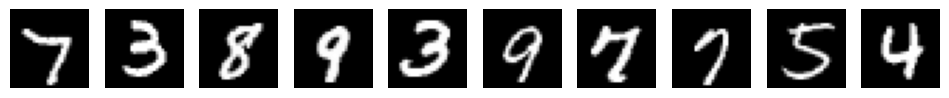

In [4]:
# Plotting 10 random images before processing the data
random_indices_before= np.random.choice(len(x_train), 10, replace=False)
random_images_before = x_train[random_indices_before]

plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(random_images_before[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.axis("off")
plt.show()

### Pre-processing of the data 

In [5]:
# Normalization using StandardScaler
scaler = StandardScaler()

x_train_standardized = scaler.fit_transform(x_train)
x_test_standardized = scaler.transform(x_test)

# Conversion to pytorch tensor
x_train_tensor = torch.tensor(x_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_standardized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Creating dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Let's plot some images again after the processing the data :

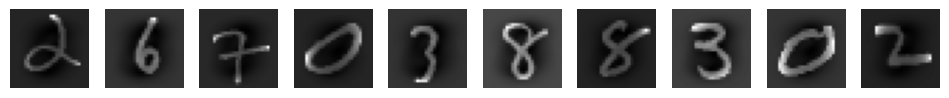

In [6]:
# Plotting 10 random images after having processed the data
random_indices_after = np.random.choice(len(x_train), 10, replace=False)
random_images_after = x_train_standardized[random_indices_after]

plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(random_images_after[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.axis("off")
plt.show()

## Device

This cell is crucial for optimizing the training time of the model. By checking if a GPU is available and setting the device accordingly, we can significantly reduce the execution time of the training process. If a GPU is present, it will be used for computation, otherwise the CPU will be used.

In [7]:
# Set to use GPU if available
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# Print device status
if device.type == "cuda":
    print("Using GPU for computation.")
else:
    print("GPU not available, using CPU.")


GPU not available, using CPU.


# Without neural network

Before utilizing neural networks, we will first explore what can be achieved using t-SNE and PCA. 

t-SNE will be primarily used to obtain a better graphical representation and to observe the differences between the various clusters that are formed. 

On the other hand, PCA will be used for data reconstruction since it does not inherently create distinct clusters.

### t-SNE

In [8]:
# Applying t-SNE on the test set 
tsne = TSNE(n_components=2, random_state=42)
x_test_tsne2D = tsne.fit_transform(x_test)

In [9]:
# Plot t-SNE embeddings in 2D 
plot_2d_embeddings(x_test_tsne2D, y_test, "t-SNE Embedding in 2D")

### PCA

In [10]:
# Applying PCA on the test set
pca = PCA(n_components=2)
x_test_pca2D = pca.fit_transform(x_test)

In [11]:
# Plot PCA embeddings in 2D 
plot_2d_embeddings(x_test_pca2D, y_test, "PCA Embedding in 2D")

As we can observe, the embedding generated by PCA is not as clear as the one produced by t-SNE. However, using PCA, we can perform the reverse operation, starting from the reduced dimension representation to reconstruct the original data. 

For the reconstruction, we will compare the original images from the test set with their corresponding reconstructed images generated by the autoencoder. We will calculate two metrics for each image pair:

- **Mean Squared Error (MSE)**: This metric measures the average squared difference between the original and reconstructed images, quantifying pixel-wise differences. A lower MSE indicates a better reconstruction.

- **Structural Similarity Index (SSIM)**: This perceptual metric assesses the similarity between two images by considering changes in structural information, luminance, and contrast. SSIM values range from -1 to 1, where 1 indicates perfect similarity [wikipedia](https://en.wikipedia.org/wiki/Structural_similarity_index_measure).

By utilizing both MSE and SSIM, we aim to thoroughly evaluate the performance of our autoencoder in terms of both numerical accuracy and perceptual quality.

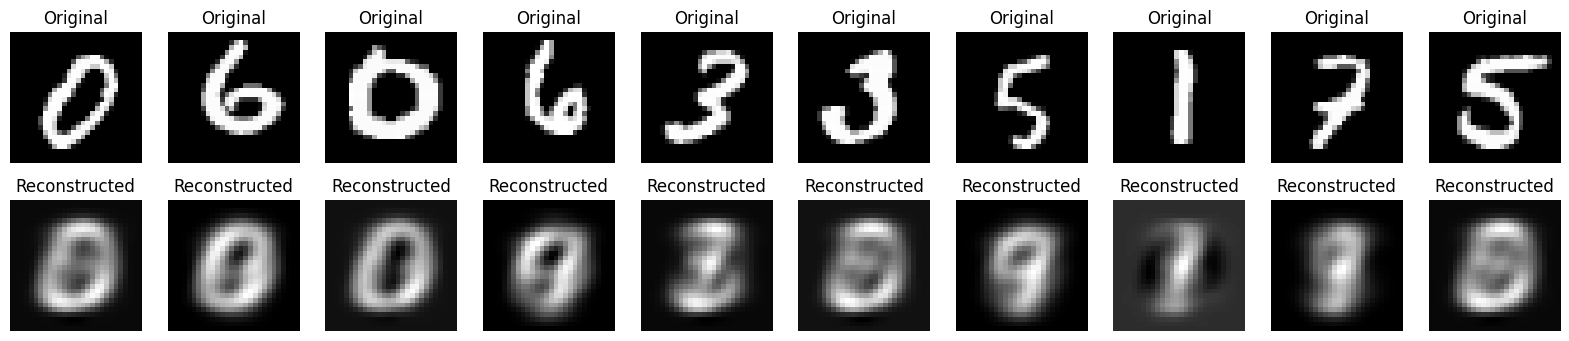

MSE and SSIM for image 0 are 3928.7742 and 0.3943

MSE and SSIM for image 1 are 4975.9077 and 0.2737

MSE and SSIM for image 2 are 4642.1069 and 0.5462

MSE and SSIM for image 3 are 3946.2573 and 0.2878

MSE and SSIM for image 4 are 4076.3669 and 0.2455

MSE and SSIM for image 5 are 4068.4626 and 0.3631

MSE and SSIM for image 6 are 3215.1265 and 0.2350

MSE and SSIM for image 7 are 1843.5533 and 0.3436

MSE and SSIM for image 8 are 3335.2437 and 0.2395

MSE and SSIM for image 9 are 4585.5698 and 0.3526

In [12]:
# Applying the inverse operation : from 2D to original data 784=28x28
x_test_reconstructed = pca.inverse_transform(x_test_pca2D)

# Select 10 random images from the test set
random_indices = np.random.choice(x_test.shape[0], 10, replace=False)

# Get the original and reconstructed images using the random indices
original_images = x_test[random_indices]
reconstructed_images = x_test_reconstructed[random_indices]

# Plotting the original and reconstructed images
plot_original_and_reconstructed(original_images, reconstructed_images)
plt.show()

In [13]:
console = Console()
# Calculate and print SSIM and MSE for all images
mean_ssim_pca = calculate_ssim(x_test, x_test_reconstructed)
console.print(f"Mean SSIM for all images: {mean_ssim_pca:.4f}")

mean_mse_pca = calculate_mse(x_test, x_test_reconstructed)
console.print(f"Mean MSE for all images: {mean_mse_pca:.4f}")

Mean SSIM for all images: 0.2999

Mean MSE for all images: 3612.1309

As we can see, the reconstruction provided by PCA is a good starting point, but there is certainly room for improvement. 

🎯 **Goal**  Provide a 2D embedding that is visually comprehensible and clear (like the one provided by t-SNE) and at the same time capable of reconstructing the original image. 

🖼️ We are talking about 28x28 images being compressed into only 2 dimensions...

# NN

We are going to train a simplified autoencoder on the MNIST dataset. An autoencoder is a type of neural network designed to learn efficient representations of data, typically for the purpose of dimensionality reduction or feature learning. It consists of two main components: an encoder and a decoder.

- **Encoder**: The encoder compresses the input image down to a lower-dimensional latent space. In our case, it reduces the input to a 2-dimensional latent space, which captures the essential features of the input while significantly reducing its dimensionality.
  
- **Decoder**: The decoder takes this 2D latent representation and attempts to reconstruct the original input image from it. The goal is for the decoder to produce an output as close as possible to the original input.

The following autoencoder is trained by minimizing the mean squared error (MSE) between the reconstructed image and the original image. By learning this efficient encoding, the autoencoder can effectively reduce the dimensionality of the data while preserving important information.

<div style="text-align: center;">
    <img src="autoencoder.png" alt="Autoencoder Architecture" width="600"/>
</div>




## Model

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) 
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training 

In [15]:
# Initialize the model, define the loss 
AE = Autoencoder().to(device)  
criterion = nn.MSELoss()

# Defining the optimizer adding L2 regularization
optimizer = optim.Adam(AE.parameters(), lr=0.01, eps=1e-8, weight_decay=1e-4)

# Define the exponential learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Create an instance of console
console = Console()

num_epochs = 50
train_losses = []
valid_losses = []


with Progress(
    TextColumn("[bold blue]{task.description}"),
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.1f}%",
    TimeRemainingColumn(),
    console=console,
) as progress:
    epoch_task = progress.add_task("[red]Training...", total=num_epochs)
    
    for epoch in range(num_epochs):
        AE.train()
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            outputs = AE(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()

        # Saving the average training loss of the epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        AE.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, _ in valid_loader:
                images = images.to(device)
                outputs = AE(images)
                loss = criterion(outputs, images)
                running_val_loss += loss.item()
        
        # Saving the average validation loss 
        valid_loss = running_val_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        
        # Step the scheduler
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            console.print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Update the progress bar
        progress.advance(epoch_task)


Output()

Epoch 10, Training Loss: 0.6356, Validation Loss: 0.6432, Learning Rate: 0.003487

Epoch 20, Training Loss: 0.6084, Validation Loss: 0.6178, Learning Rate: 0.001216

Epoch 30, Training Loss: 0.5938, Validation Loss: 0.6030, Learning Rate: 0.000424

Epoch 40, Training Loss: 0.5860, Validation Loss: 0.5983, Learning Rate: 0.000148

Epoch 50, Training Loss: 0.5814, Validation Loss: 0.5971, Learning Rate: 0.000052

### Save the parameters

In [16]:
torch.save(AE.state_dict(), 'AE_parameters.pth')

# In case you want to use the network for inference, you can load the parameters using the following command:
# AE.load_state_dict(torch.load('AE_parameters.pth'))
# and set the model to "evaluation" mode:
# AE.eval()


### Experimental Results

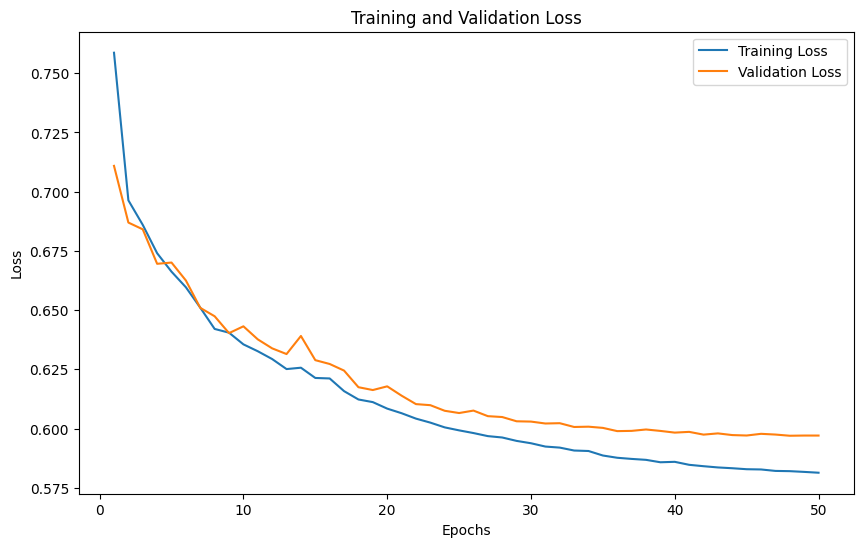

In [16]:
# After training is complete, plot the losses
plot_losses(train_losses, valid_losses, num_epochs)

## Evaluation

As stated initially, our goal is to perform dimensionality reduction using a simple neural network. Specifically, we will evaluate our network's ability to reconstruct the original data, as the loss function is designed to enforce this. Additionally, we will visualize the learned embedding in 2D.

- **Reconstruction Capability**: 🛠️ The primary focus will be on how well the network can reconstruct the initial data. This will be quantitatively assessed using the loss function.
- **2D Embedding Visualization**: 🖼️ We will create 2D visualizations of the learned embeddings to qualitatively assess the performance of the dimensionality reduction.

By combining these two evaluation methods, we aim to ensure that our neural network effectively reduces dimensionality while preserving the essential structure of the data.

### Reconstruction Capability 

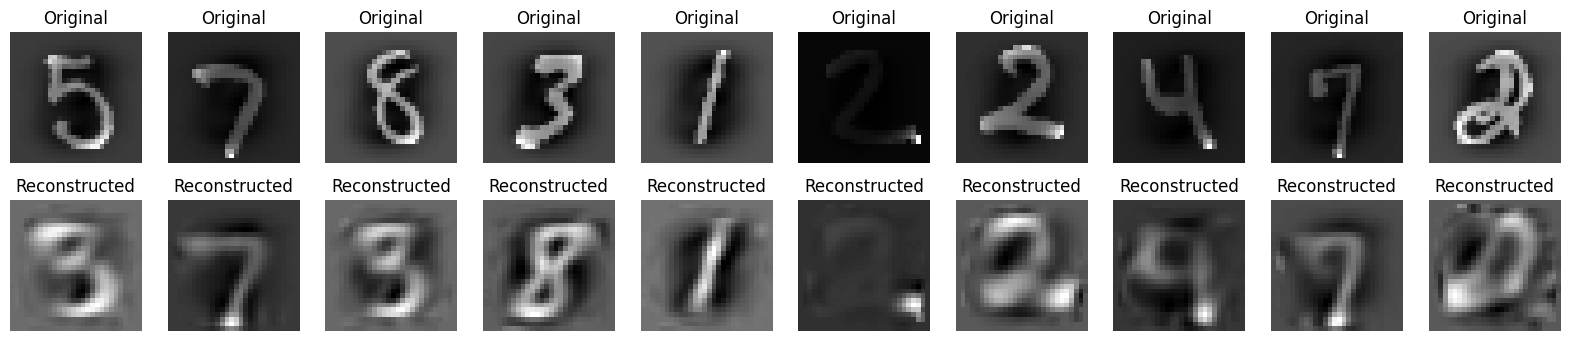

MSE and SSIM for image 0 are 0.3650 and 0.2908

MSE and SSIM for image 1 are 0.2068 and 0.5686

MSE and SSIM for image 2 are 0.3019 and 0.2797

MSE and SSIM for image 3 are 0.2720 and 0.3021

MSE and SSIM for image 4 are 0.0652 and 0.7666

MSE and SSIM for image 5 are 2.8414 and 0.4484

MSE and SSIM for image 6 are 0.4296 and 0.2957

MSE and SSIM for image 7 are 0.4406 and 0.2537

MSE and SSIM for image 8 are 0.1491 and 0.4720

MSE and SSIM for image 9 are 0.3653 and 0.2034

In [17]:
# Evaluate and plot test figures vs. predicted figures

original_imgs, decoded_imgs = evaluate_autoencoder(AE, valid_loader, device)
# Select 10 random images from the test set
random_indices = np.random.choice(len(original_imgs), 10, replace=False)
original_images = original_imgs[random_indices]
reconstructed_images = decoded_imgs[random_indices]

# Plotting the original and reconstructed images
plot_original_and_reconstructed(original_images, reconstructed_images)
plt.show()


In [18]:
# Calculate and print SSIM and MSE for all images
mean_ssim = calculate_ssim(original_imgs, decoded_imgs)
console.print(f"Mean SSIM for all images: {mean_ssim:.4f}")

mean_mse = calculate_mse(original_imgs, decoded_imgs)
console.print(f"Mean MSE for all images: {mean_mse:.4f}")

Mean SSIM for all images: 0.3699

Mean MSE for all images: 0.5991

### 2D Embedding 

In [19]:
# Assuming you have a test_loader or valid_loader to visualize the embeddings
plot_embeddings(AE, valid_loader,device)

### Exploring the learnt embedding

This code snippet defines a function to visualize the reconstructed images by sampling from the latent space of the autoencoder. The function `plot_sampling` generates a grid of points in the latent space, decodes these points to reconstruct images, and plots the reconstructed images in a single large image. This visualization helps to understand how the latent space is organized and how well the autoencoder has learned to represent the data.

By examining the changes in the reconstructed images as we sample different points in the latent space, we can gain insights into how the values within the learnt latent space correspond to different features in the input data. This allows us to see the transitions and variations that the autoencoder captures, providing a deeper understanding of the latent representations.

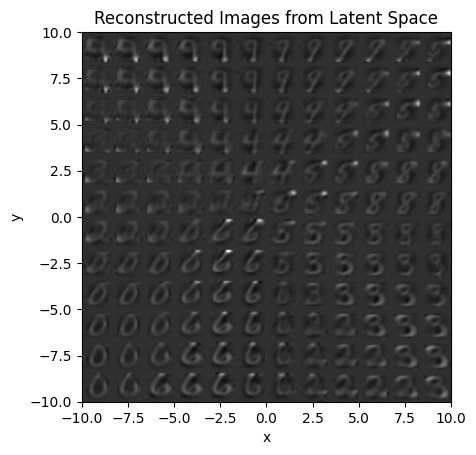

In [20]:
# Set the model to evaluation mode
AE.eval()

# Define the range for sampling latent space coordinates
x_range = (-10, 10)
y_range = (-10, 10)

# Plot reconstructed images by sampling from the latent space
plot_sampling(AE, r0=x_range, r1=y_range, n=12, device=device)



Based on the observations from this evaluation section, we can see that in terms of "reconstruction," the neural network (NN) has provided better results compared to PCA. However, when it comes to visualizing the embedding, further modifications are necessary.

# Custom Loss


### Motivation for Modifying the Loss Function

Having observed that, in terms of reconstruction, although not perfect, our autoencoder provides a more detailed reconstruction compared to PCA, we aim to modify the loss function to better preserve the structure of the original data. For instance, we expect a clear separation between different digits. To achieve this, we are modifying the loss function by adding cross-entropy loss and updating the autoencoder with an additional layer after the decoder for classification. 

🔍 **Detailed Reconstruction**: While the reconstruction is not flawless, it captures more details than PCA.

🧩 **Preserving Structure**: By adding cross-entropy loss, we aim to maintain the separation between different digits, expecting the network to classify the digits correctly. This encourages the network to distinguish more precisely between distinct digits.

🎯 **Enhanced Embeddings**: With this modification, the learned embeddings will not only represent the data in a compressed form but also capture class-specific information, leading to well-separated clusters for each digit in the latent space.

By inducing the network to classify correctly through cross-entropy loss, we aim to achieve embeddings that better reflect the underlying structure of the data, ultimately leading to clearer, more distinct clusters for each digit in the 2D embedding space.



## Model

In [21]:
class Autoencoder_Custom(nn.Module):
    def __init__(self):
        super(Autoencoder_Custom, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784)
        )
        self.classifier = nn.Sequential(
            nn.Linear(784, 10),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(decoded)
        return decoded, classified



## Training

In [22]:
# Loss functions
reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

# Model, optimizer, and scheduler
AE_custom = Autoencoder_Custom().to(device)  
optimizer = optim.Adam(AE_custom.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Create an instance of Console
console = Console()

# Training loop
num_epochs_custom = 50
train_losses_custom = []
valid_losses_custom = []
train_accuracies_custom = []
valid_accuracies_custom = []


with Progress(
    TextColumn("[bold blue]{task.description}"),
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.1f}%",
    TimeRemainingColumn(),
    console=console,
) as progress:
    epoch_task = progress.add_task("[red]Training...", total=num_epochs_custom)
    
    for epoch in range(num_epochs_custom):
        AE_custom.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)  
            optimizer.zero_grad()
            
            # Compute model prediction
            decoded, classified = AE_custom(data)
            
            # Compute losses
            reconstruction_loss = reconstruction_criterion(decoded, data)
            classification_loss = classification_criterion(classified, target)
            total_loss = reconstruction_loss + classification_loss
            
            total_loss.backward()
            optimizer.step()
            
            # Compute the batch loss and add it to the epoch loss
            running_loss += total_loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(classified.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        # Saving the average training loss of the epoch
        train_loss = running_loss / len(train_loader)
        train_losses_custom.append(train_loss)
        
        # Saving the average training accuracy of the epoch
        train_accuracy = correct_train / total_train
        train_accuracies_custom.append(train_accuracy)

        
        AE_custom.eval()
        running_val_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)  
                decoded, classified = AE_custom(data)
                
                # Compute validation losses
                reconstruction_loss = reconstruction_criterion(decoded, data)
                classification_loss = classification_criterion(classified, target)
                total_loss = reconstruction_loss + classification_loss
                running_val_loss += total_loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(classified.data, 1)
                total_valid += target.size(0)
                correct_valid += (predicted == target).sum().item()
        
        # Saving the average validation loss of the epoch
        valid_loss = running_val_loss / len(valid_loader)
        valid_losses_custom.append(valid_loss)
        
        # Saving the average validation accuracy of the epoch
        valid_accuracy = correct_valid / total_valid
        valid_accuracies_custom.append(valid_accuracy)
        
        # Step the scheduler
        scheduler.step()

        # Print the training and validation loss along with learning rate and accuracy every 10 epochs
        if (epoch + 1) % 10 == 0:
            console.print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, "
                          f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}, "
                          f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        
        # Update the progress bar
        progress.advance(epoch_task)

print("Training complete")


Output()

Epoch 10, Training Loss: 1.0348, Validation Loss: 1.0183, Training Accuracy: 0.9431, Validation Accuracy: 0.9485, 
Learning Rate: 0.003487

Epoch 20, Training Loss: 0.8942, Validation Loss: 0.9471, Training Accuracy: 0.9741, Validation Accuracy: 0.9615, 
Learning Rate: 0.001216

Epoch 30, Training Loss: 0.8359, Validation Loss: 0.9273, Training Accuracy: 0.9831, Validation Accuracy: 0.9647, 
Learning Rate: 0.000424

Epoch 40, Training Loss: 0.8042, Validation Loss: 0.9280, Training Accuracy: 0.9862, Validation Accuracy: 0.9649, 
Learning Rate: 0.000148

Epoch 50, Training Loss: 0.7915, Validation Loss: 0.9440, Training Accuracy: 0.9882, Validation Accuracy: 0.9642, 
Learning Rate: 0.000052

Training complete


### Saving parameters

In [24]:
torch.save(AE_custom.state_dict(), 'AE_custom_parameters.pth')
# # In case you want to use the network for inference, you can load the parameters using the following command:
# AE_custom.load_state_dict(torch.load('AE_custom_parameters.pth'))
# and set the model to "evaluation" mode:
# AE_custom.eval()  

### Experimental Results

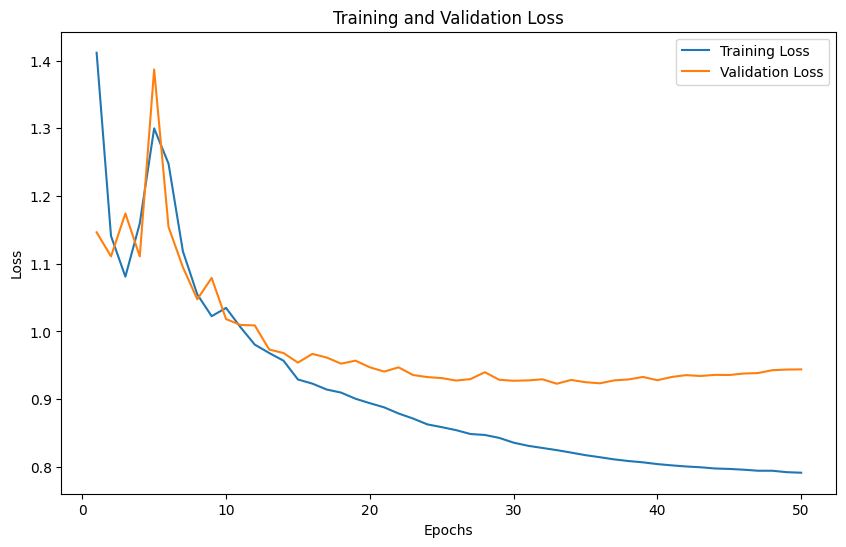

In [23]:
# After training is complete, plot the losses
plot_losses(train_losses_custom, valid_losses_custom, num_epochs_custom)

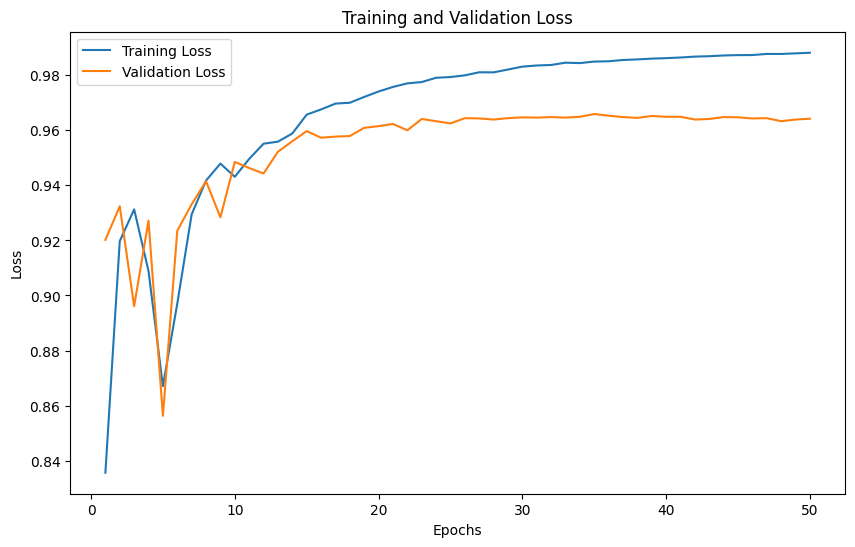

In [24]:
# After training is complete, plot the accuracy 
plot_losses(train_accuracies_custom, valid_accuracies_custom, num_epochs_custom)

## Evaluation

### Reconstruction Capability 

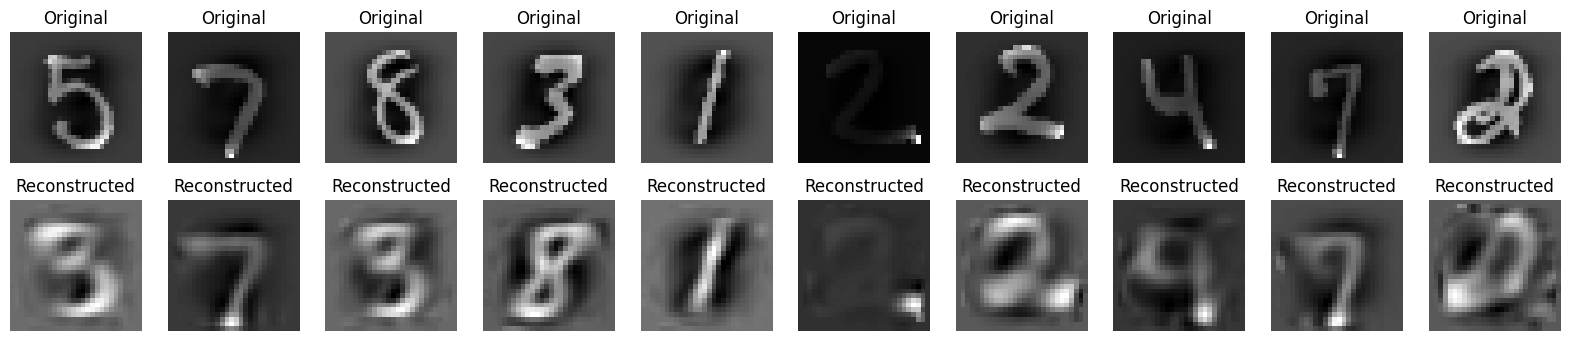

MSE and SSIM for image 0 are 0.3650 and 0.2908

MSE and SSIM for image 1 are 0.2068 and 0.5686

MSE and SSIM for image 2 are 0.3019 and 0.2797

MSE and SSIM for image 3 are 0.2720 and 0.3021

MSE and SSIM for image 4 are 0.0652 and 0.7666

MSE and SSIM for image 5 are 2.8414 and 0.4484

MSE and SSIM for image 6 are 0.4296 and 0.2957

MSE and SSIM for image 7 are 0.4406 and 0.2537

MSE and SSIM for image 8 are 0.1491 and 0.4720

MSE and SSIM for image 9 are 0.3653 and 0.2034

In [25]:
original_imgs_custom, decoded_imgs_custom = evaluate_autoencoder_custom(AE_custom, valid_loader, device)

# Select 10 random images from the test set
random_indices = np.random.choice(len(original_imgs_custom), 10, replace=False)
original_images_custom = original_imgs_custom[random_indices]
reconstructed_images_custom = decoded_imgs_custom[random_indices]

# Plotting the original and reconstructed images
plot_original_and_reconstructed(original_images, reconstructed_images)

In [26]:
# Calculate and print SSIM and MSE for all images
mean_ssim_custom = calculate_ssim(original_imgs_custom, decoded_imgs_custom)
console.print(f"Mean SSIM for all images: {mean_ssim_custom:.4f}")

mean_mse_custom = calculate_mse(original_imgs_custom, decoded_imgs_custom)
console.print(f"Mean MSE for all images: {mean_mse_custom:.4f}")

Mean SSIM for all images: 0.2671

Mean MSE for all images: 0.7468

### 2D Embedding 

In [27]:
# Assuming you have a test_loader or valid_loader to visualize the embeddings
plot_embeddings(AE_custom, valid_loader, device)

### Exploring the learnt embedding

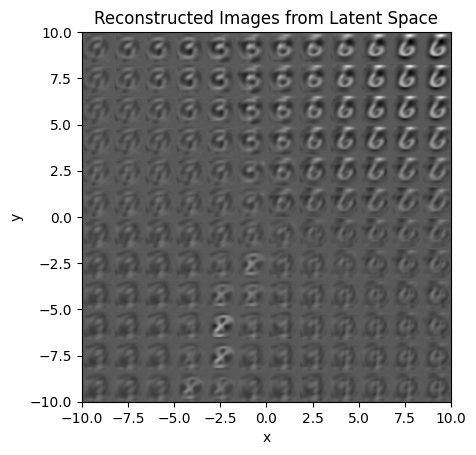

In [28]:
# Define the range for sampling latent space coordinates
x_range_custom = (-10, 10)
y_range_custom = (-10, 10)

# Plot reconstructed images by sampling from the latent space
plot_sampling(AE_custom, r0=x_range_custom, r1=y_range_custom, n=12, device=device)


Here are the final observations after evaluating the performance of two models:

What we can observe after training the two autoencoders with different loss functions is that in both cases, we achieve a significantly better image reconstruction compared to using PCA. However, as indicated by the SSIM factor, the reconstruction quality is not outstanding. On the other hand, we need to consider the different times required to achieve the reconstruction: a few seconds for PCA and a few minutes for the two linear autoencoder models.

Representing the latent space with only 2 components out of 784 was intentional to visualize the embeddings in 2D and observe if clusters could be formed, similar to t-SNE. We can say that by customizing the loss function, we have somewhat achieved this result. 🎉


# Can We Do Better? Exploring Probabilistic Approaches with VAEs

In the context of dimensionality reduction, traditional autoencoders map input data to a latent space deterministically. However, incorporating a probabilistic approach (as in t-SNE )can provide significant advantages.

By representing latent variables as distributions, we can capture more complex data structures and ensure better generalization. This probabilistic approach is found in Variational Autoencoders (VAEs), which enhance autoencoders by modeling the latent space probabilistically, combining reconstruction loss with a regularization term to maintain a structured and meaningful latent space. 🌌✨ 

For this final section, inspiration is drawn from the concepts outlined in [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) and the code provided in this [GitHub repository](https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb).


# Pre-processing of the dataset

In [29]:
(x_train_vae, y_train_vae), (x_test_vae, y_test_vae) = load_data_impl()

# Convert back to [0, 1] range
scaler = MinMaxScaler()

x_train_normalized = scaler.fit_transform(x_train_vae)
x_test_normalized = scaler.fit_transform(x_test_vae)

# Conversion to pytorch tensor
x_train_tensor_vae = torch.tensor(x_train_normalized, dtype=torch.float32)
y_train_tensor_vae = torch.tensor(y_train, dtype=torch.long)
x_test_tensor_vae = torch.tensor(x_test_normalized, dtype=torch.float32)
y_test_tensor_vae = torch.tensor(y_test, dtype=torch.long)

# Creating dataset
train_dataset_vae = TensorDataset(x_train_tensor_vae, y_train_tensor_vae)
test_dataset_vae = TensorDataset(x_test_tensor_vae, y_test_tensor_vae)

# Creating dataloader
train_loader_vae = DataLoader(train_dataset_vae, batch_size=128, shuffle=True)
valid_loader_vae = DataLoader(test_dataset_vae, batch_size=128, shuffle=False)

## Model

In [31]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU()
        )
        
        # Latent mean and variance
        self.mean_layer = nn.Linear(32, 2)
        self.logvar_layer = nn.Linear(32, 2)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,784),
            nn.Sigmoid()
        )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def sampling(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        #epsilon = torch.randn_like(std)
        #z = mean + std * epsilon
        # the reparameterization trick
        z = torch.distributions.Normal(loc=mean, scale=std).rsample()
        return z
    
    def decode(self, z):
        z = self.decoder(z)
        return z


    def forward(self, x):
        mean, logvar = self.encode(x.view(-1,784))
        z = self.sampling(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [32]:
def loss_function(x, recon_x , mean, logvar):
    reproduction_loss = F.binary_cross_entropy(recon_x, x , reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + KLD

## Training

In [33]:
# Instantiate the model, optimizer, and scheduler
model_VAE = VAE().to(device)
optimizer_VAE = optim.Adam(model_VAE.parameters())

# Define the exponential learning rate scheduler
scheduler_VAE = ExponentialLR(optimizer_VAE, gamma=0.9)

# Initialize variables for tracking losses
num_epochs_VAE = 60
train_losses_VAE = []
valid_losses_VAE = []

console = Console()

# Training loop with rich progress bar
with Progress() as progress:
    train_task = progress.add_task("[cyan]Training...", total=num_epochs_VAE)

    for epoch in range(num_epochs_VAE):
        model_VAE.train()
        running_train_loss = 0.0

        for data, _ in train_loader_vae:
            data = data.to(device)  # Transfer data to the correct device
            optimizer_VAE.zero_grad()

            x_hat, mean, logvar = model_VAE(data.view(-1, 784))
            loss = loss_function(data, x_hat, mean, logvar)
            
            loss.backward()
            optimizer_VAE.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader_vae.dataset)
        train_losses_VAE.append(train_loss)

        model_VAE.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for data, _ in valid_loader_vae:
                data = data.to(device)
                x_hat, mean, logvar = model_VAE(data.view(-1, 784))
                loss = loss_function(data, x_hat, mean, logvar)

                running_val_loss += loss.item()

        valid_loss = running_val_loss / len(valid_loader_vae.dataset)
        valid_losses_VAE.append(valid_loss)

        scheduler_VAE.step()
        # Print the training and validation loss along with learning rate and accuracy every 10 epochs
        if (epoch + 1) % 10 == 0:
            console.print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, "
                          f"Learning Rate: {scheduler_VAE.get_last_lr()[0]:.6f}")
            
        #console.print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")#, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        progress.advance(train_task)

console.print("Training complete")



Output()

Epoch 10, Training Loss: 153.1052, Validation Loss: 153.2612, Learning Rate: 0.000349

Epoch 20, Training Loss: 149.1926, Validation Loss: 150.2862, Learning Rate: 0.000122

Epoch 30, Training Loss: 147.9961, Validation Loss: 149.3152, Learning Rate: 0.000042

Epoch 40, Training Loss: 147.5869, Validation Loss: 149.0378, Learning Rate: 0.000015

Epoch 50, Training Loss: 147.4325, Validation Loss: 149.0077, Learning Rate: 0.000005

Epoch 60, Training Loss: 147.3691, Validation Loss: 148.8885, Learning Rate: 0.000002

Training complete

### Saving parameters

In [ ]:
torch.save(model_VAE.state_dict(), 'VAE_parameters.pth')
# # In case you want to use the network for inference, you can load the parameters using the following command:
# model_VAE.load_state_dict(torch.load('VAE_parameters.pth'))
# and set the model to "evaluation" mode:
# model_VAE.eval()  

### Experimental results

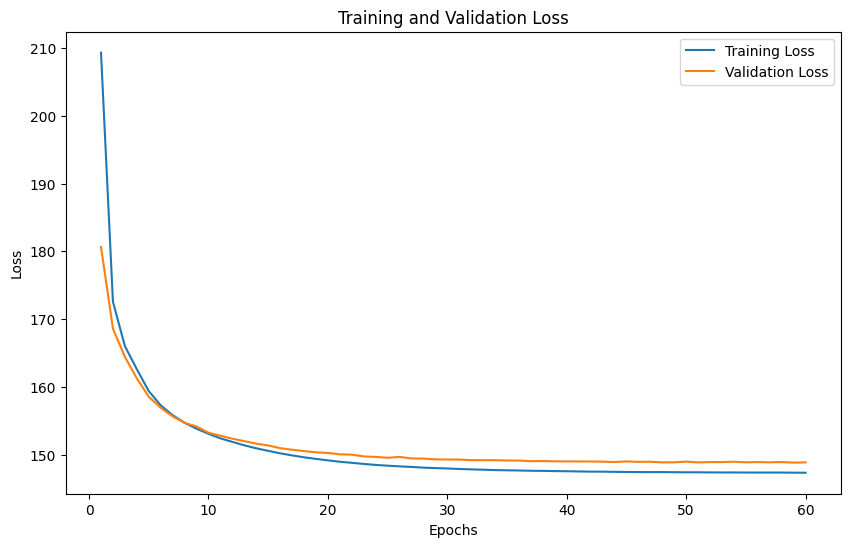

In [34]:
# After training is complete, plot the losses
plot_losses(train_losses_VAE, valid_losses_VAE, num_epochs_VAE)

## Evaluation

### Reconstruction Capability 

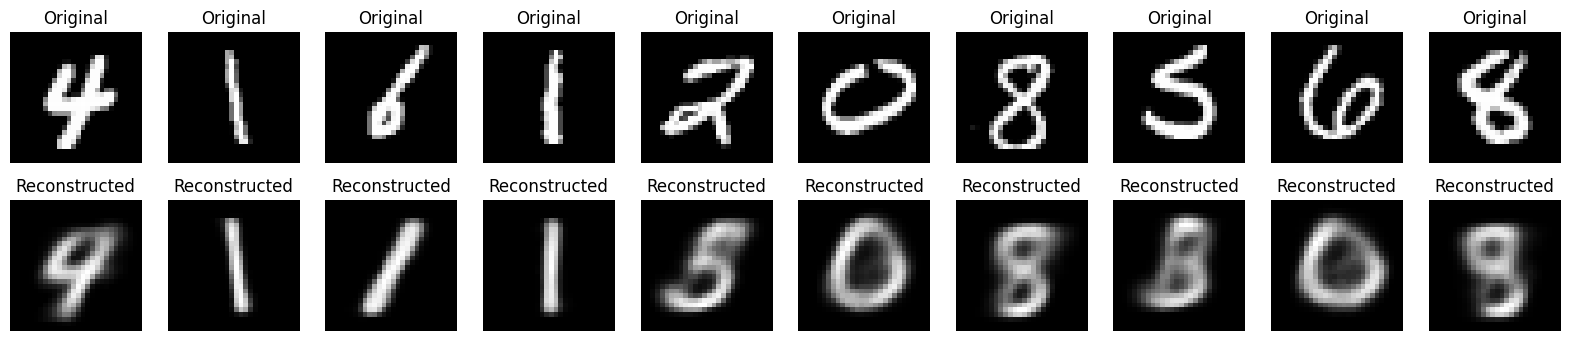

MSE and SSIM for image 0 are 0.0348 and 0.6174

MSE and SSIM for image 1 are 0.0060 and 0.8758

MSE and SSIM for image 2 are 0.0299 and 0.6769

MSE and SSIM for image 3 are 0.0067 and 0.9010

MSE and SSIM for image 4 are 0.0896 and 0.2790

MSE and SSIM for image 5 are 0.0841 and 0.2923

MSE and SSIM for image 6 are 0.0439 and 0.4911

MSE and SSIM for image 7 are 0.0650 and 0.3434

MSE and SSIM for image 8 are 0.0454 and 0.4716

MSE and SSIM for image 9 are 0.0587 and 0.4483

In [35]:
original_imgs_vae, decoded_imgs_vae = evaluate_autoencoder_vae(model_VAE, valid_loader_vae, device)

# Select 10 random images from the test set
random_indices = np.random.choice(len(original_imgs_vae), 10, replace=False)
original_images_vae = original_imgs_vae[random_indices]
reconstructed_images_vae = decoded_imgs_vae[random_indices]

# Plotting the original and reconstructed images
plot_original_and_reconstructed(original_images_vae, reconstructed_images_vae)



In [36]:
# Calculate and print SSIM and MSE for all images
mean_ssim_vae = calculate_ssim(original_imgs_vae, decoded_imgs_vae)
console.print(f"Mean SSIM for all images: {mean_ssim_vae:.4f}")

mean_mse_vae = calculate_mse(original_imgs_vae, decoded_imgs_vae)
console.print(f"Mean MSE for all images: {mean_mse_vae:.4f}")

Mean SSIM for all images: 0.5460

Mean MSE for all images: 0.0406

### 2D Embedding

In [37]:
# Plot 2D embeddings with sampling
plot_embeddings_with_sampling(model_VAE, valid_loader_vae, device)

### Exploring the learnt embedding

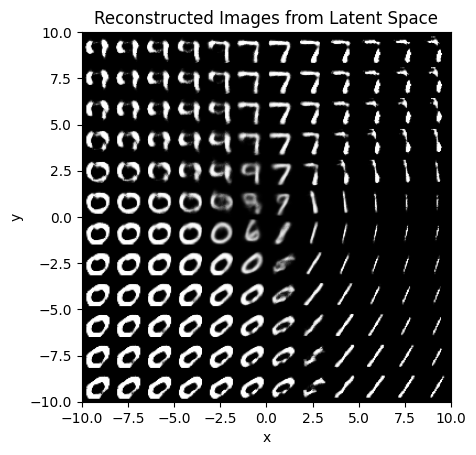

In [38]:
# Set the model to evaluation mode
model_VAE.eval()

# Define the range for sampling latent space coordinates
x_range_vae = (-10, 10)
y_range_vae = (-10, 10)

# Plot reconstructed images by sampling from the latent space
plot_sampling(model_VAE, r0=x_range_vae, r1=y_range_vae, n=12, device=device)

### Conclusions and Observations:

In conclusion, it can be observed that using Variational Autoencoders (VAEs) results in superior image reconstruction when evaluating the two considered metrics, MSE and SSIM. Additionally, the latent space representation shows a clear clustering of digits while maintaining smooth transitions between them. This is evident from the section "Exploring the Learnt Embedding" and the imposition of a normal distribution on the latent space.

However, it is important to note that the MSE and SSIM values of the different trained models are not significantly distinct from each other. This lack of pronounced difference is likely due to the simplicity of the MNIST dataset used. The reconstruction criteria were employed as extrinsic characteristics of the embeddings learned by the three distinct models. This means that while the models provide comparable performance in terms of reconstruction metrics, the true test of their capabilities would be better observed with a more complex dataset.

Lastly, the decision to use only two dimensions for the latent space representation was primarily driven by the desire to create an interpretable graphical representation. Training the models on higher-dimensional latent spaces would likely yield better reconstruction results and could help identify the minimal dimension necessary to compress a 28x28 image from the MNIST dataset. This exploration could lead to more insights into the model's capacity and efficiency. 🔍📊